In [1]:
import sys  
sys.path.insert(0, '../')

from connection_to_db import connection

sys.path.insert(0, '/')

from preprocess import preprocess as preprocess_data

In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [3]:
departures_test_name = 'departures_to_test'
departures_train_name = 'departures'

weather_test_name = 'weather_predict'
weather_train_name = 'weather'

In [4]:
_, conn, cur = connection()

In [5]:
def get_data(connection, table_name, weather_table_name, is_train=False):
    query = f'''
        SELECT * 
        FROM {table_name}
        LEFT JOIN {weather_table_name} ON {weather_table_name}.datetime = {table_name}.datetime_round
    '''
    if is_train:
        query += ' WHERE delay IS NOT NULL'
    data = pd.read_sql(query, connection)
    return data

In [6]:
def additional_preprocess(data):
    data = data.drop(columns=['scheduled_datetime', 'date']).fillna(0)
    return data

In [7]:
test = get_data(conn, departures_test_name, weather_test_name)
test = preprocess_data(test)
test = additional_preprocess(test)
test = test.drop(columns=['delay'])
test.head()

,carrier_code,flight,destination_airport,temp,humidity,precip,preciptype,snowdepth,windgust,windspeed,...,cloudcover,visibility,solarradiation,conditions,winspeed_greater_17,is_freezing_rain,is_first_day_half,weekday,is_weekend,season
0,51,7454,8,38.0,88.6,0.4,4,0.2,33.3,20.8,...,100.0,1.6,0.0,0,1,0,False,3,False,3
1,51,7452,8,38.0,88.6,0.4,4,0.2,33.3,20.8,...,100.0,1.6,0.0,0,1,0,False,3,False,3
2,51,7458,8,38.0,88.6,0.4,4,0.2,33.3,20.8,...,100.0,1.6,0.0,0,1,0,False,3,False,3
3,51,7456,8,38.0,88.6,0.4,4,0.2,33.3,20.8,...,100.0,1.6,0.0,0,1,0,False,3,False,3
4,16,6444,110,38.0,88.6,0.4,4,0.2,33.3,20.8,...,100.0,1.6,0.0,0,1,0,False,3,False,3


In [10]:
train = get_data(conn, departures_train_name, weather_train_name)
train = preprocess_data(train, is_data_train=True)
train.head()

,carrier_code,flight,destination_airport,scheduled_datetime,date,delay,temp,humidity,precip,preciptype,...,cloudcover,visibility,solarradiation,conditions,winspeed_greater_17,is_freezing_rain,is_first_day_half,weekday,is_weekend,season
0,68,3001,193,20:35:00,2022-07-16,0.0,70.2,78.5,0.0,2,...,97.4,9.9,7.0,5,0,0,False,5,True,1
1,68,3010,193,08:42:00,2022-07-16,0.0,68.1,89.8,0.0,2,...,100.0,8.3,83.0,5,0,0,True,5,True,1
2,68,3015,118,08:18:00,2022-07-16,0.0,68.1,89.8,0.0,2,...,100.0,8.3,83.0,5,0,0,True,5,True,1
3,68,3032,101,10:30:00,2022-07-16,0.0,70.3,83.8,0.0,2,...,99.4,8.9,287.0,5,0,0,True,5,True,1
4,68,3045,118,19:47:00,2022-07-16,0.0,71.2,75.7,0.0,2,...,96.4,9.9,35.0,5,0,0,False,5,True,1


In [28]:
def split_train(data):
    max_date = data['date'].max()
    train_old = data[data['date'] < max_date]
    train_new = data[data['date'] == max_date]
    return train_old, train_new

train_old, train_new = split_train(train)
train_old = additional_preprocess(train_old)
train_new = additional_preprocess(train_new)

In [29]:
y = np.log(train_old['delay'].to_numpy() + 1)
X = train_old.drop(columns=['delay']).to_numpy()

y_val = train_new['delay']
X_val = train_new.drop(columns=['delay']).to_numpy()

In [13]:
train_old

,carrier_code,flight,destination_airport,delay,temp,humidity,precip,preciptype,snowdepth,windgust,...,cloudcover,visibility,solarradiation,conditions,winspeed_greater_17,is_freezing_rain,is_first_day_half,weekday,is_weekend,season
0,68,3001,193,0.0,70.2,78.5,0.0,2,0.0,9.2,...,97.4,9.9,7.0,5,0,0,False,5,True,1
1,68,3010,193,0.0,68.1,89.8,0.0,2,0.0,10.5,...,100.0,8.3,83.0,5,0,0,True,5,True,1
2,68,3015,118,0.0,68.1,89.8,0.0,2,0.0,10.5,...,100.0,8.3,83.0,5,0,0,True,5,True,1
3,68,3032,101,0.0,70.3,83.8,0.0,2,0.0,7.8,...,99.4,8.9,287.0,5,0,0,True,5,True,1
4,68,3045,118,0.0,71.2,75.7,0.0,2,0.0,11.0,...,96.4,9.9,35.0,5,0,0,False,5,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323794,68,5866,128,35.0,72.2,83.3,0.0,2,0.0,12.1,...,97.1,9.9,116.0,5,0,0,True,4,False,1
323795,68,5988,54,0.0,69.5,94.6,0.0,3,0.0,20.4,...,97.2,9.9,410.0,1,0,0,True,4,False,1
323796,68,5994,15,0.0,70.2,86.4,0.0,3,0.0,11.9,...,100.0,9.9,5.0,1,0,0,False,4,False,1
323797,68,5999,68,140.0,67.1,90.2,0.0,3,0.0,9.2,...,100.0,6.9,30.0,1,0,0,True,4,False,1


In [27]:
random_forest = RandomForestRegressor(n_jobs=-1, verbose=2)
random_forest.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.4s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.7s finished


RandomForestRegressor(n_jobs=-1, verbose=2)

In [30]:
(((np.exp(random_forest.predict(X_val)) - 1) - y_val)**2).mean()

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


1907.4559281672023

In [34]:
np.sqrt(((
    (np.exp(random_forest.predict(X_val)) - 1) - y_val)**2).mean())

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


43.67443105716664

In [36]:
(np.exp(random_forest.predict(X_val)) - 1)[:10]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


array([ 1.21591734,  1.21591734,  1.21591734,  1.21591734, 17.45478023,
        3.86279806,  2.47322408,  3.25246707,  1.22405619,  3.28624069])

In [37]:
y_val[:10]

169871      0.0
169872      0.0
169873      0.0
169874      0.0
169875     16.0
169876      0.0
169877      0.0
169878    501.0
169879      0.0
169880      7.0
Name: delay, dtype: float64

In [38]:
(np.abs((np.exp(random_forest.predict(X_val)) - 1) - y_val)).mean()

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


11.69882916896942

In [42]:
y_val - np.exp(random_forest.predict(X_val))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


169871    -2.215917
169872    -2.215917
169873    -2.215917
169874    -2.215917
169875    -2.454780
            ...    
170799     5.908828
170800    30.088058
170801    -4.717678
170802    45.494570
170803    10.546244
Name: delay, Length: 933, dtype: float64

In [46]:
import matplotlib.pyplot as plt

(array([2.15935e+05, 1.58520e+04, 2.58690e+04, 2.72020e+04, 2.19340e+04,
        1.28250e+04, 2.66800e+03, 5.28000e+02, 5.20000e+01, 1.00000e+00]),
 array([0.        , 0.86988479, 1.73976957, 2.60965436, 3.47953914,
        4.34942393, 5.21930872, 6.0891935 , 6.95907829, 7.82896307,
        8.69884786]),
 <BarContainer object of 10 artists>)

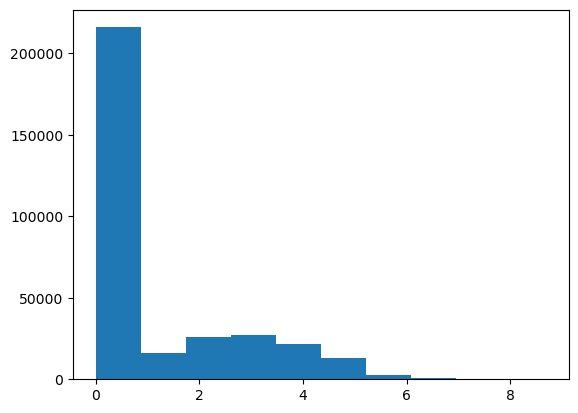

In [48]:
plt.hist(y)